# Checking FRET effect in spectra assays

In [1]:
from assaytools import platereader
from glob import glob

import matplotlib.pyplot as plt

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from lxml import etree
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns

sns.set(style='white')
sns.set_context('talk')

In [3]:
#This function allows us to import a section from an xml formated data file and convert itto a pandas dataframe
def xml2df_section(file,section):

    root = etree.parse(file)

    data = []

    reads = root.xpath("/*/Section[%s]/*/Well"%section)
    Sections = root.xpath("/*/Section")
    print Sections[(section-1)].attrib['Name'] 
    section_name = Sections[(section-1)].attrib['Name'] 
    
    wellIDs = [read.attrib['Pos'] for read in reads]

    data = [(s.text, float(s.attrib['WL']), r.attrib['Pos'])
        for r in reads
        for s in r]
    
    dataframe = pd.DataFrame(data, columns=['fluorescence','wavelength (nm)','Well'])
            
    ### dataframe_rep replaces 'OVER' (when fluorescence signal maxes out) with '3289277', an arbitrarily high number

    dataframe_rep = dataframe.replace({'OVER':'3289277'})

    dataframe_rep[['fluorescence']] = dataframe_rep[['fluorescence']].astype('float')
            
    dataframe_pivot = pd.pivot_table(dataframe_rep, index = 'wavelength (nm)', columns = ['Well'])
    
    #Rearrange columns so they're in the right order
    cols =  dataframe_pivot['fluorescence'].columns.tolist()
    cols = [cols[0]] + cols[4:12] + cols[1:4] + [cols[12]] + cols[16:23] + cols[13:16]
    dataframe_reindex =  dataframe_pivot.reindex_axis(cols,level='Well',axis=1)
    
    return [dataframe_reindex,section_name]

In [4]:
#This function allows us to plot spectra choosing ylim and 
def plot_spectra_grid_advanced(file_set,protein,ligands,ligand,section,ylim,lines):
    grid = len(protein) + len(ligand)

    file = file_set[protein]
    
    # make a dataframe
    [df,section_name] = xml2df_section(file,section)
    
    # pick a title
    title = "%s - %s: %s" %(protein, ligand, section_name)

    # define ylim and lines
    
    ylim = ylim
    lines = lines
    
    # plot the spectra
    fig = plt.figure(figsize=(8,6));
    ax = df['fluorescence'].iloc[:,12].plot(ylim=(0,ylim),legend=False, linewidth=4,color='m',title=title);
    for line in lines:
        ax.axvline(x=line,color='0.7',linestyle='--');
    for i in range(11):
        df['fluorescence'].iloc[:,i].plot(linewidth=3,c=cm.hsv(i*15), ax = ax);
        df['fluorescence'].iloc[:,11+i].plot(legend=False, linewidth=4,c=cm.gray(i*15+50), ax = ax, fontsize =20);
    sns.despine()
    plt.xlim(300,600)
    plt.xlabel('wavelength (nm)', fontsize=20)
    plt.text(550,0.9*ylim,"lines=%s"%lines,color='0.7')
    plt.tight_layout();

In [5]:
file_set = {'Abl': "/Users/hansons/Documents/github/fluorescence-assay-manuscript/data/spectra/Abl/2016-03-11/Abl_D382N_BosI_20160311_135952.xml"}
ligands = ['BosutinibIsomer']

In [6]:
ylim = 500000
lines = [340,480]

em280


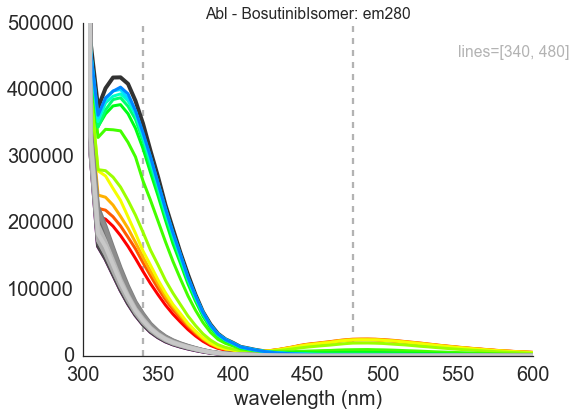

In [7]:
plot_spectra_grid_advanced(file_set,'Abl',ligands,'BosutinibIsomer',1,ylim,lines)

In [8]:
ylim = 50000
lines = [340,480]

em280


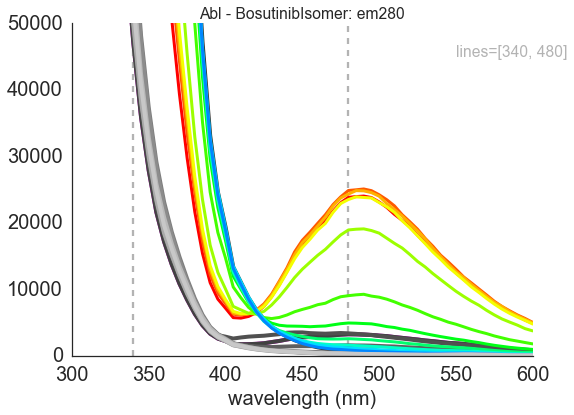

In [9]:
plot_spectra_grid_advanced(file_set,'Abl',ligands,'BosutinibIsomer',1,ylim,lines)

In [11]:
protein='Abl'
section=1
file = file_set[protein]
    
# make a dataframe
[df,section_name] = xml2df_section(file,section)

em280


In [12]:
#Let's find our max for our protein fluorescence, making a new df_FP dataframe
FP_mask = (df.index > 311) & (df.index < 380)
df_FP = df.loc[FP_mask]

In [13]:
df_FP['fluorescence'].idxmax().max()

325.0

In [14]:
df_FP.values.max()

418795.0

In [15]:
#Let's do the same for our ligand fluorescence, making a new df_FL dataframe
FL_mask = (df.index > 430) & (df.index < 580)
df_FL = df.loc[FL_mask]

In [16]:
df_FL['fluorescence'].idxmax().max()

490.0

In [17]:
df_FL.values.max()

25085.0

em280


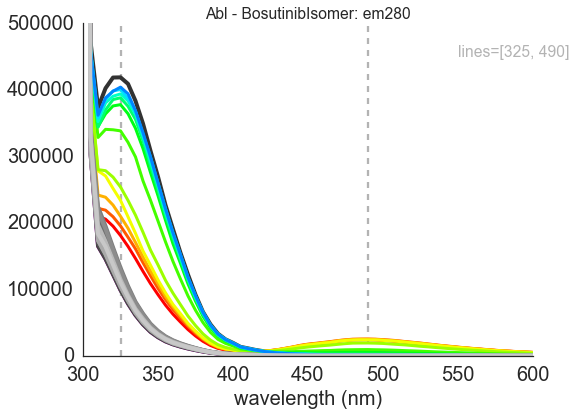

In [18]:
ylim = 500000
lines = [325,490]
plot_spectra_grid_advanced(file_set,'Abl',ligands,'BosutinibIsomer',1,ylim,lines)

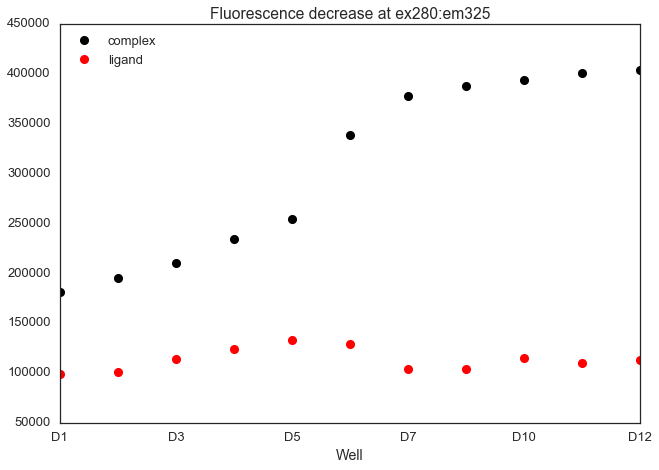

In [26]:
df['fluorescence'].loc[325][:11].plot(marker='o',color='k',linestyle='None',label='complex')
df['fluorescence'].loc[325][12:23].plot(marker='o',color='r',linestyle='None',label='ligand')
plt.legend(loc=0);
plt.title('Fluorescence decrease at ex280:em325');

em280


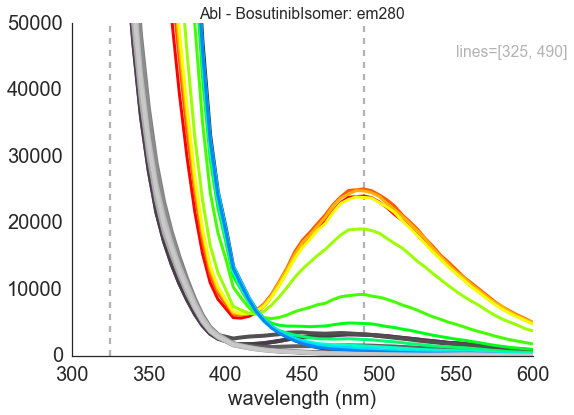

In [19]:
ylim = 50000
lines = [325,490]
plot_spectra_grid_advanced(file_set,'Abl',ligands,'BosutinibIsomer',1,ylim,lines)

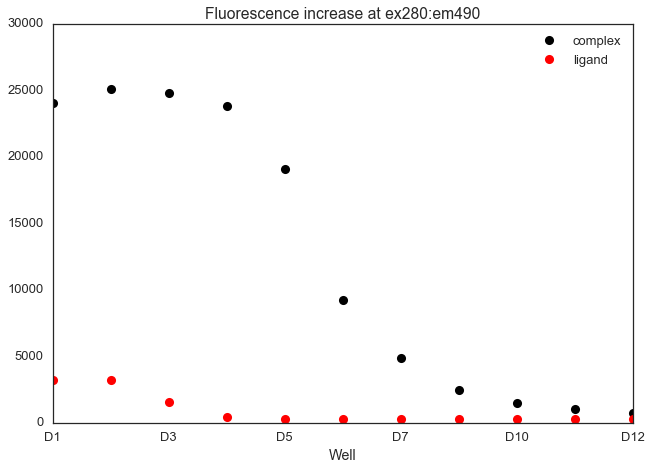

In [27]:
df['fluorescence'].loc[490][:11].plot(marker='o',color='k',linestyle='None',label='complex')
df['fluorescence'].loc[490][12:23].plot(marker='o',color='r',linestyle='None',label='ligand')
plt.legend(loc=0);
plt.title('Fluorescence increase at ex280:em490');

In [28]:
#Now let's normalize the fluorescence so we can plot these on the same plot
df_FPnorm = df.divide(df_FP.values.max())
df_FLnorm = df.divide(df_FL.values.max())

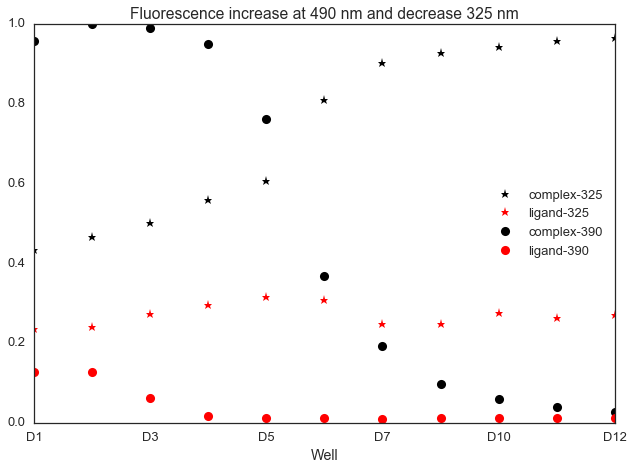

In [29]:
df_FPnorm['fluorescence'].loc[325][:11].plot(marker='*',color='k',linestyle='None',label='complex-325')
df_FPnorm['fluorescence'].loc[325][12:23].plot(marker='*',color='r',linestyle='None',label='ligand-325')
df_FLnorm['fluorescence'].loc[490][:11].plot(marker='o',color='k',linestyle='None',label='complex-390')
df_FLnorm['fluorescence'].loc[490][12:23].plot(marker='o',color='r',linestyle='None',label='ligand-390')
plt.legend(loc=0);
plt.title('Fluorescence increase at 490 nm and decrease 325 nm');

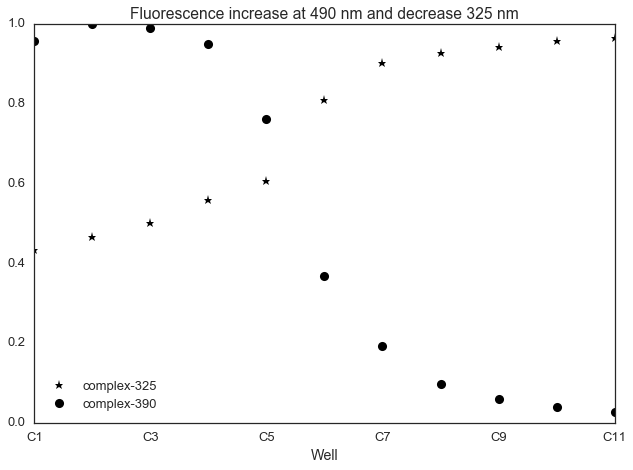

In [31]:
#Little easier to see without the ligand fluorescnece
df_FPnorm['fluorescence'].loc[325][:11].plot(marker='*',color='k',linestyle='None',label='complex-325')
#df_FPnorm['fluorescence'].loc[325][12:23].plot(marker='*',color='r',linestyle='None',label='ligand-325')
df_FLnorm['fluorescence'].loc[490][:11].plot(marker='o',color='k',linestyle='None',label='complex-390')
#df_FLnorm['fluorescence'].loc[490][12:23].plot(marker='o',color='r',linestyle='None',label='ligand-390')
plt.legend(loc=0);
plt.title('Fluorescence increase at 490 nm and decrease 325 nm');